# Hypothesis testing with BayesDB

##### Prepared by Ulrich Schaechtle, PhD.

## Preamble

This notebook is demonstrating hypothesis testing with BayesDB. 

**The demo is using early stage alpha version research software.** The demo is not
intended to be used as is -- it won't scale to larger datasets and the
interfaces described don't implement a reusable workflow. 
Instead it is intended to provide a snapshot of our current
capability to solicit interest in BayesDB.

One candidate beta version tailored to a scalable workflow will be able to deal
with 100 000 rows and 1000 columns. A key question we will address in the research for this beta version is 
how dataset size, amount of computation, and accuracy of a synthetic data 
generator interact with predictive accuracy.

## BayesDB

BayesDB is a probabilistic programming platform that provides built-in non-parametric Bayesian model discovery.
BayesDB makes it easy for users without statistics training to search, clean, and model multivariate databases using an SQL-like language.  In this notebook, we demonstrate how BayesDB can be used for hypothesis testing.
The work is based on research results published here:

* _Detecting dependencies in sparse, multivariate databases using probabilistic programming and non-parametric Bayes._ Saad, F.; and Mansinghka, V. K. In Artificial Intelligence and Statistics 20 (AISTATS), volume 54, pages 632–641. PMLR, 2017 [(link)](http://proceedings.mlr.press/v54/saad17a/saad17a.pdf).
* _Bayesian synthesis of probabilistic programs for automatic data modeling._ Saad, F. A.; Cusumano-Towner, M. F.; Schaechtle, U.; Rinard, M. C.; and Mansinghka, V. K. Proceedings of the ACM on Programming Languages, 3(POPL): 37:1-37:29. January 2019 [(link)](https://dl.acm.org/citation.cfm?doid=3302515.3290350&fbclid=IwAR2GLpIo7YW2g_lSMpJDsgb2KZOIEX0dos5DZz2Vg1BcQBKbGTA3F5B_mmA).
* _Crosscat: A fully Bayesian, nonparametric method for analyzing heterogeneous, high-dimensional data._ Mansinghka, V. K.; Shafto, P.; Jonas, E.; Petschulat, C.; Max, G.; and Tenenbaum, J. B. Journal of Machine Learning Research, 17(138): 1-49. 2016. [(link)](http://jmlr.org/papers/volume17/11-392/11-392.pdf).

## Aim of this notebook

The purpose of this notebook is twofold. First, we will provide a tutorial on
probabilistic program synthesis for data modeling and analysis. Second, we show how the
synthesized programs can be used for analysis.
Both will be demoed using openly available RNA sequencing data (see the [notebook for
download and pre-processing here](data-preprocessing.ipynb)). The notebook focuses on the
on arabinose regulation and the operon of araC, the main gene involved in arabinose
catabolism and transport.

![operon](operon.png "operon of araC")

## Capabilities demonstrated in this notebook

### 1. Tutorial: Population assembly.

The notion of a "population" is a central concept in BayesDB.

### 2. Tutorial: Probabilistic program synthesis.

We synthesize generative models as probabilistic programs.

### 3. Tutorial: Inspecting synthesis results. 

We perform a quick, visual predictive check to assess whether our inference
converged.

### 4. Simple hypothesis testing: BayesDB agrees with linear statistics. 

We confirm that one experimental treatment should not effect the other.

### 5. Simple hypothesis testing: BayesDB finds a dependency that linear statistics misses.

We show a case where two genes are informative for each other because they
live on the same [operon](https://ecocyc.org/gene?orgid=ECOLI&id=EG10054#tab=TU).

### 6. Causal hypothesis testing: BayesDB finds a evidence for a causal structure.

We demonstrate testing of causal hypotheses.


-------------

#### Setting up the Jupyter environment

The first step is to load the `jupyter_probcomp.magics` library, which provides BayesDB hooks for data exploration, plotting, querying, and analysis through this Jupyter notebook environment. 

It enables us to use three languages in the Jupyter cells below:
1. **BQL**. The Bayesian Query Language. This allows us to query a Bayesian database [(documentation)](http://probcomp.csail.mit.edu/dev/bayesdb/doc/bql.html).
2. **MML**. The Meta Modeling Language. This allows us to define the generative model that will model populations of interest.


All of the cells  below are by default python cells. We use the `%%` and `%`
decorators to change the default behavior of jupyter.
`%%bql` will introduce a whole cell of BQL code whereas  `%bql`
only marks the current line to be interpreted as BQL and the rest of the cell is
python.

In [1]:
%load_ext jupyter_probcomp.magics

session_id: jovyan@ulli-notebook_2019-04-04T23:50:06.351053_6


The cell allows plots from matplotlib and javascript to be shown inline.

In [2]:
%matplotlib inline
%vizgpm inline

<IPython.core.display.Javascript object>

We load some helper functions for plotting.

In [3]:
run helper_functions.py

#### Creating a BayesDB `.bdb` file on disk

We next use the `%bayesdb` magic to create a `.bdb` file on disk named `bayesian_database.bdb`. This file will store all the data and models created in this session.

In [4]:
%bayesdb bayesian-database.bdb 

u'Loaded: bayesian-database.bdb'

## 1. Tutorial: Population assembly

#### Ingesting data from a `.csv` file into a BayesDB table

We load the data we [previously created](data-munging.ipynb) from a csv file.Each column of the csv file is a variable, and each row is a record. We use the `CREATE TABLE` BQL query, with the pathname of the csv file, to convert the csv data into a database table named `data`.

In [5]:
%bql CREATE TABLE "data" FROM 'rna-seq-araD-treatment.csv'

#### Running basic queries on the table using BQL and SQL

Now that the dataset has been loaded into at table, we can run standard SQL queries to explore the contents of the data.
For example, we can select the first 5 records. Observe that each row in the
table is a particular measurement, and each column is either a gene or an
experimental treatment.

In [6]:
%bql SELECT * FROM "data" LIMIT 5;

,araC,araB,araA,araD,arabinose,glucose
0,8.789793,13.260900,13.228167,12.101567,8.822814,0.117327
1,8.845097,13.257600,13.297267,12.171334,8.187836,1.277665
2,9.337717,13.426900,13.398266,12.312567,8.973789,-0.591571
3,8.891520,13.219534,13.311500,12.187900,9.849130,0.547097
4,9.246210,13.345467,13.288033,12.176267,8.091947,-0.202193


In [7]:
# Confirm the number of rows.
%bql SELECT COUNT(*) AS "N rows in table" FROM "data";

,N rows in table
0,305.0


#### Creating a BayesDB population for the RNAseq data

The notion of a "population" is a central concept in BayesDB. For a standard
database table, such as `data`, each column is associated with a
[data type](https://sqlite.org/datatype3.html), which in sqlite3 are
`TEXT`, `REAL`, `INTEGER`, and `BLOB`. For a BayesDB population, each variable
is associated with a _statistical data type_. 
In this tutorial, we will use the `NUMERICAL` and `NOMINAL` statistical data types (the latter for categorical random variables that take discrete values).

We can use the `GUESS SCHEMA FOR <table>` command from the Metamodeling Language
(MML) in BayesDB to guess the statistical data types of variables in the table. 

The guesses use heuristics based on the contents in the cells. 


In [8]:
%%mml
CREATE POPULATION FOR "data" WITH SCHEMA (
    GUESS STATTYPES OF (*);
);

In [9]:
%bql .interactive_pairplot --population=data SELECT "araC", "araB",  "arabinose", "glucose" FROM data

<IPython.core.display.Javascript object>

## 2. Tutorial: Probabilistic program synthesis.

Now that we have created the population, the next step is to analyze the data by
synthezising probabilistic models as probabilistic programs which explain the data
generating process. Probabilistic program synthesis for automated modeling in
BayesDB is specified by declaring `GENERATOR` for a population (see
[Bayesian synthesis of probabilistic programs for automatic data modeling](https://dl.acm.org/citation.cfm?doid=3302515.3290350&fbclid=IwAR2GLpIo7YW2g_lSMpJDsgb2KZOIEX0dos5DZz2Vg1BcQBKbGTA3F5B_mmA)
). The default generator in BayesDB is based on Cross-Categorization [(Crosscat)](http://jmlr.org/papers/v17/11-392.html). The CrossCat generator is a Bayesian factorial mixture model which learns a full joint distribution over all variables in the population, using a divide-and-conquer approach. We will explore CrossCat more in this notebook.

For now we use MML to declare the a generator for the population. Note that that we have left the schema (there are not specific model commands or overrides), which will apply the built-in default model discovery strategies.


In [10]:
%mml CREATE GENERATOR FOR "data";

We turn BayesDB's multiprocessing on.

In [11]:
%multiprocess on

Multiprocessing turned on from off.


#### Bayesian inference

After creating the generator, we now need to initialize `MODELS` for the
generator. We can think of a `GENERATOR` as specifying a hypothesis space of
explanations for the data generating process for the population, and each
`MODEL` is a candidate hypothesis. We start by creating only 30 models, which
are initialized __randomly__. You can also think of those model random
initializations of 30 chains to run MCMC on (next cell).

In [12]:
%mml INITIALIZE 30 MODELS IF NOT EXISTS FOR "data";

We run Gibbs sampling for 5 minutes for each chain to reach an approximation of
the posterior distribution that will allow us to draw synthetic data samples
from.

**Caveat:** For each chain a single available CPU is
used. `%multiprocess on` tells BayesDB to run each available CPU in parallel. Thus,
if we initialize 30 models/MCMC chains and run analysis for `5 MINUTES` but only have 6
CPUs available, the cell will run for 25 minutes, 5 times it will run 6 models/MCMC chains
in parallel for 6 minutes

In [13]:
%mml ANALYZE "data" FOR 5 MINUTES (QUIET);

Let's inspect the synthesized programs. **Caveat**: The following is stubbed. We synthesized the Metaprob programs with a pre-alpha prototype that we can't hand over yet. For this demo, we simply load previously
synthesized files from disk.

In [14]:
n_models = 10 # For now, let's only export code for 10 out of the 30 models in the ensemble.
bdb = %get_bdb
code = load_synthesized_code(bdb, n_models=n_models)

Because there are 30 models in the ensemble, there is a lot of code. We print
only the first model in the ensemble:

In [15]:
print code[125:4365] # Let's print one of the synthesized models.



(define data-generating-process-model-0
    (gen []
            ;; Column grouping for view: araC, arabinose
        (define cluster-id-for-araC-arabinose
            (categorical [0.599820 0.287668 0.031969 0.028648 0.051894]))
        (define [araC-mean araC-std]
            (cond
                (= cluster-id-for-araC-arabinose 0) [7.828788 0.634979]
                (= cluster-id-for-araC-arabinose 1) [9.113765 0.566170]
                (= cluster-id-for-araC-arabinose 2) [13.453001 0.743700]
                (= cluster-id-for-araC-arabinose 3) [9.806452 0.454566]
                (= cluster-id-for-araC-arabinose 4) [8.355788 0.674934]))
        (define araC
            (gaussian araC-mean araC-std))

        (define [arabinose-mean arabinose-std]
            (cond
                (= cluster-id-for-araC-arabinose 0) [0.121399 1.020788]
                (= cluster-id-for-araC-arabinose 1) [8.173614 0.864407]
                (= cluster-id-for-araC-arabinose 2) [16.493410 1.154188]
    

## 3. Tutorial: Inspecting synthesis results. 


We use BQL's `SIMULATE` query to generate synthetic data from the synthezided programs. Note that we
are simulating jointly from 6 columns -- if we wish to simulate the entire table we can
simply mention all columns in the able in the query. We can also sample from conditional
distributions using the phrase `GIVEN` in the query.

We escape to python to simplify plotting below.

In [16]:
table_simulate   = %bql \
SIMULATE  \
    "araD", \
    "araA", \
    "araB", \
    "glucose", \
    "arabinose", \
    "araC" \
FROM "data" \
LIMIT 305

We also save the observed data in a python dataframe.

In [17]:
table_select   = %bql \
SELECT  \
    "araD", \
    "araA", \
    "araB", \
    "glucose", \
    "arabinose", \
    "araC" \
FROM "data"

We'd like to use the two tables, `table_simulate` and `table_select` to asses
how well BayesDB models the observed data. We do this by performing a simple, visual predictive check. We plot the generated data and check if what we synthetically generated agrees with the observed data.

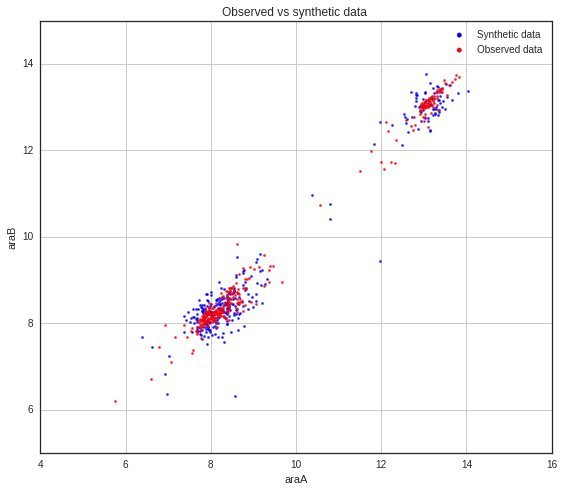

In [18]:
columns = ["araA", "araB"]
plot_virtual_data(table_select[columns], table_simulate[columns]);

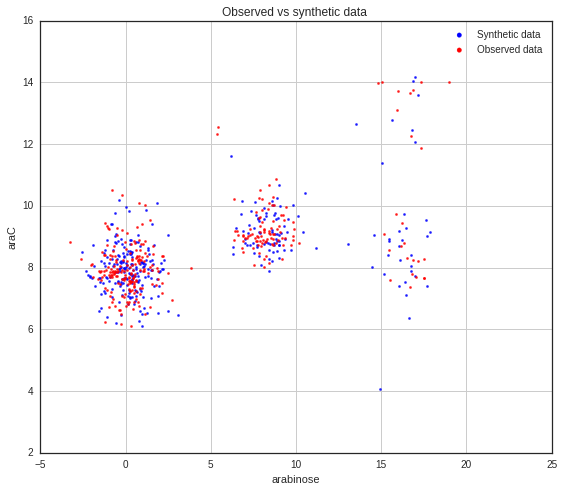

In [19]:
columns = ["arabinose", "araC"]
plot_virtual_data(table_select[columns], table_simulate[columns]);

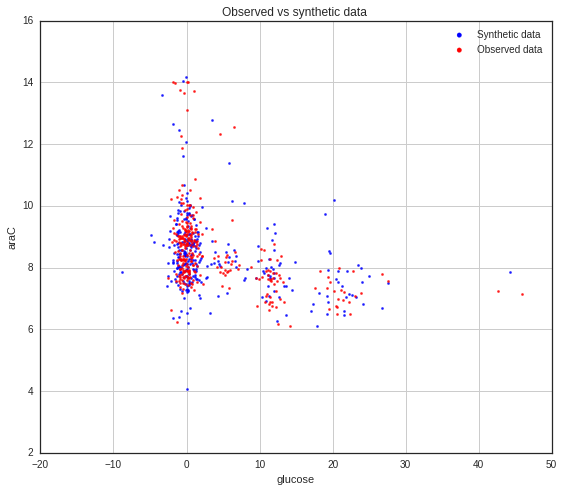

In [20]:
columns = ["glucose", "araC"]
plot_virtual_data(table_select[columns], table_simulate[columns]);

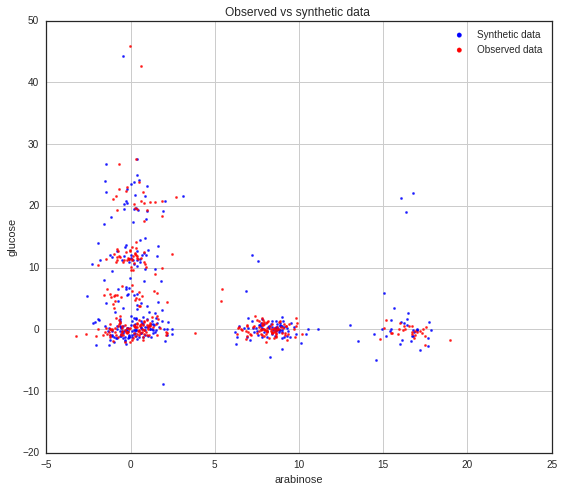

In [21]:
columns = ["arabinose", "glucose"]
plot_virtual_data(table_select[columns], table_simulate[columns]);

How does the code organize dependent columns in the data generator? Let's inspect
the ensemble to find out. Dependent columns are grouped together and form a multivariate mixture model.
For example, in the following code snippet from the first model in the ensemble,
AraC and arabinose are grouped together in the code:
```
        (define cluster-id-for-araC-arabinose
            (categorical [0.599820 0.287668 0.031969 0.028648 0.051894]))
        (define [araC-mean araC-std]
            (cond
                (= cluster-id-for-araC-arabinose 0) [7.813161 0.634979]
                (= cluster-id-for-araC-arabinose 1) [9.185628 0.566170]
                (= cluster-id-for-araC-arabinose 2) [13.299314 0.743700]
                (= cluster-id-for-araC-arabinose 3) [9.725188 0.454566]
                (= cluster-id-for-araC-arabinose 4) [8.269303 0.674934]))
        (define araC
            (gaussian araC-mean araC-std))

        (define [arabinose-mean arabinose-std]
            (cond
                (= cluster-id-for-araC-arabinose 0) [0.078673 1.020788]
                (= cluster-id-for-araC-arabinose 1) [8.193512 0.864407]
                (= cluster-id-for-araC-arabinose 2) [16.518427 1.154188]
                (= cluster-id-for-araC-arabinose 3) [-0.151569 0.996753]
                (= cluster-id-for-araC-arabinose 4) [16.605226 0.732904]))
        (define arabinose
            (gaussian arabinose-mean arabinose-std))
```
First, a cluster ID (corresponding to a single mixture component) is sampled 
```
        (define cluster-id-for-araC-arabinose
            (categorical [0.599820 0.287668 0.031969 0.028648 0.051894]))
```
The cluster ID determines the parameterization of the Gaussian distributions for
araC and arabinose.

We can inspect all the synthesized cluster IDs:


In [22]:
for line_of_code in code.split("\n"):
    if 'define cluster-id' in line_of_code:
        print line_of_code

        (define cluster-id-for-araC-arabinose
        (define cluster-id-for-araB-araA-araD
        (define cluster-id-for-glucose
        (define cluster-id-for-araB-araC-araA-araD-arabinose-glucose
        (define cluster-id-for-araB-araC-araA-araD-arabinose-glucose
        (define cluster-id-for-araC-arabinose
        (define cluster-id-for-araB-araA-araD
        (define cluster-id-for-glucose
        (define cluster-id-for-araB-araC-araA-araD-arabinose-glucose
        (define cluster-id-for-araB-araC-araA-araD-arabinose-glucose
        (define cluster-id-for-araB-araC-araA-araD-arabinose-glucose
        (define cluster-id-for-araB-araC-araA-araD-arabinose
        (define cluster-id-for-glucose
        (define cluster-id-for-araB-araC-araA-araD-arabinose-glucose
        (define cluster-id-for-araB-araC-araA-araD-arabinose
        (define cluster-id-for-glucose


This information can be used to create a causal graphical model summarizing the
data-generating process in every model of the ensemble. 

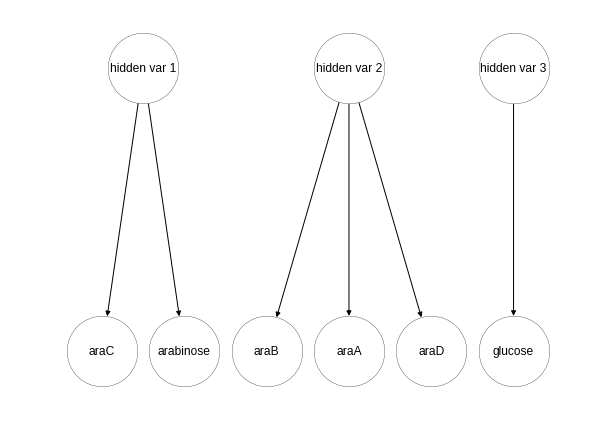

In [23]:
model_index = 0
render_dependence(get_dependence_from_code(model_index, code))

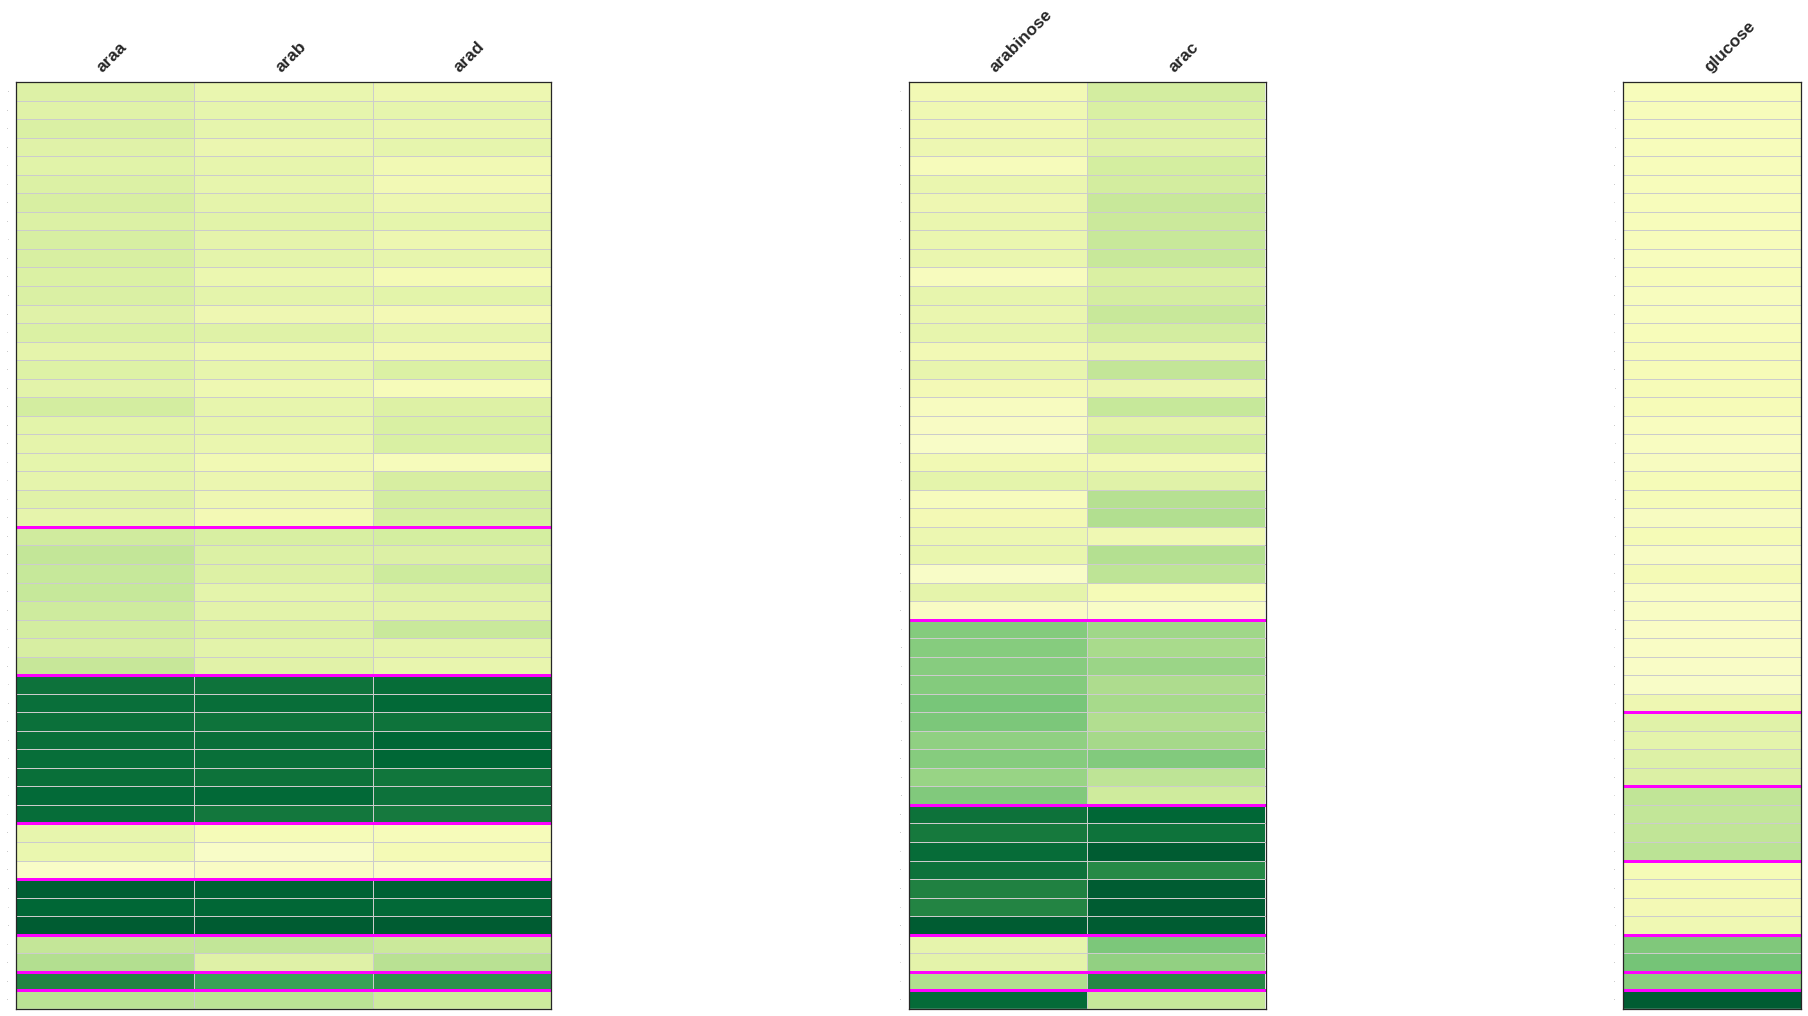

In [24]:
%mml .render_crosscat --subsample=50 data 0

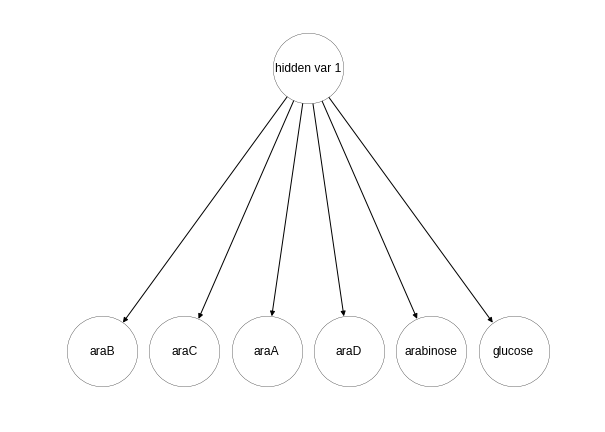

In [25]:
model_index = 1
render_dependence(get_dependence_from_code(model_index, code))

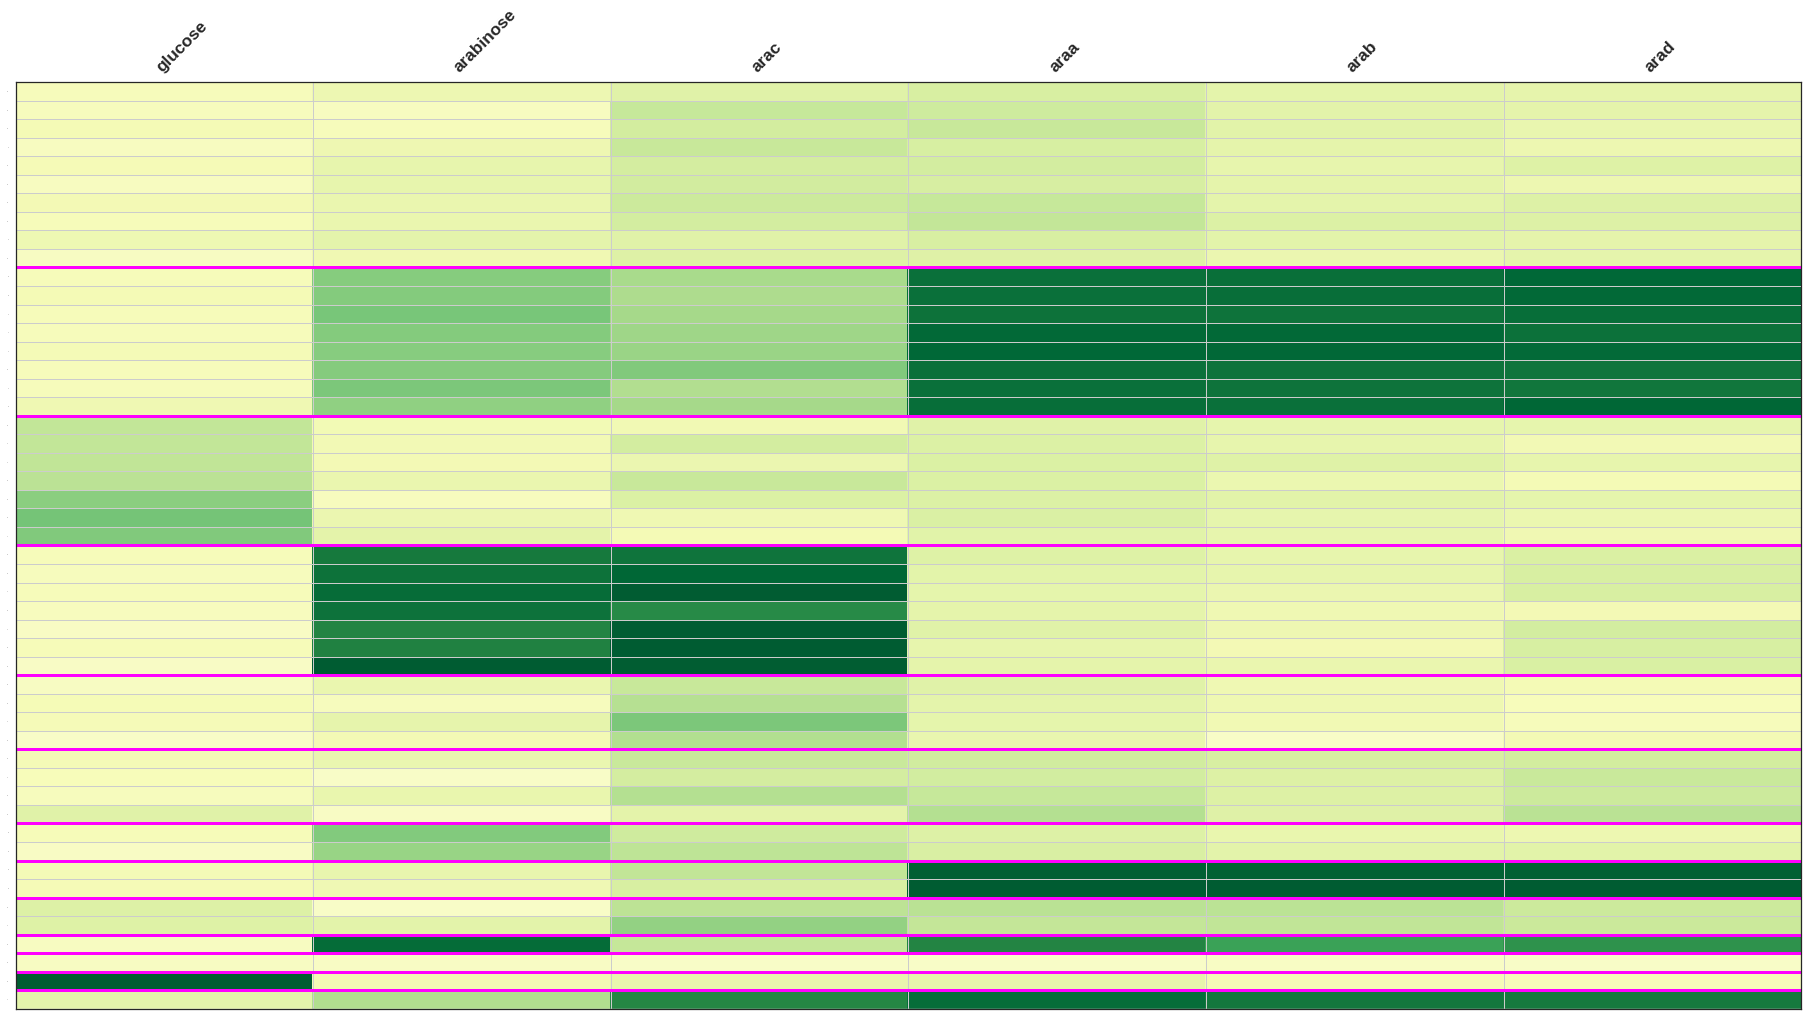

In [26]:
%mml .render_crosscat --subsample=50 data 1

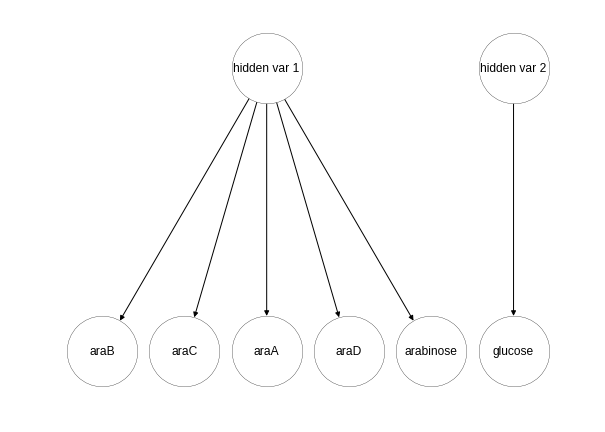

In [27]:
model_index = 7
render_dependence(get_dependence_from_code(model_index, code))

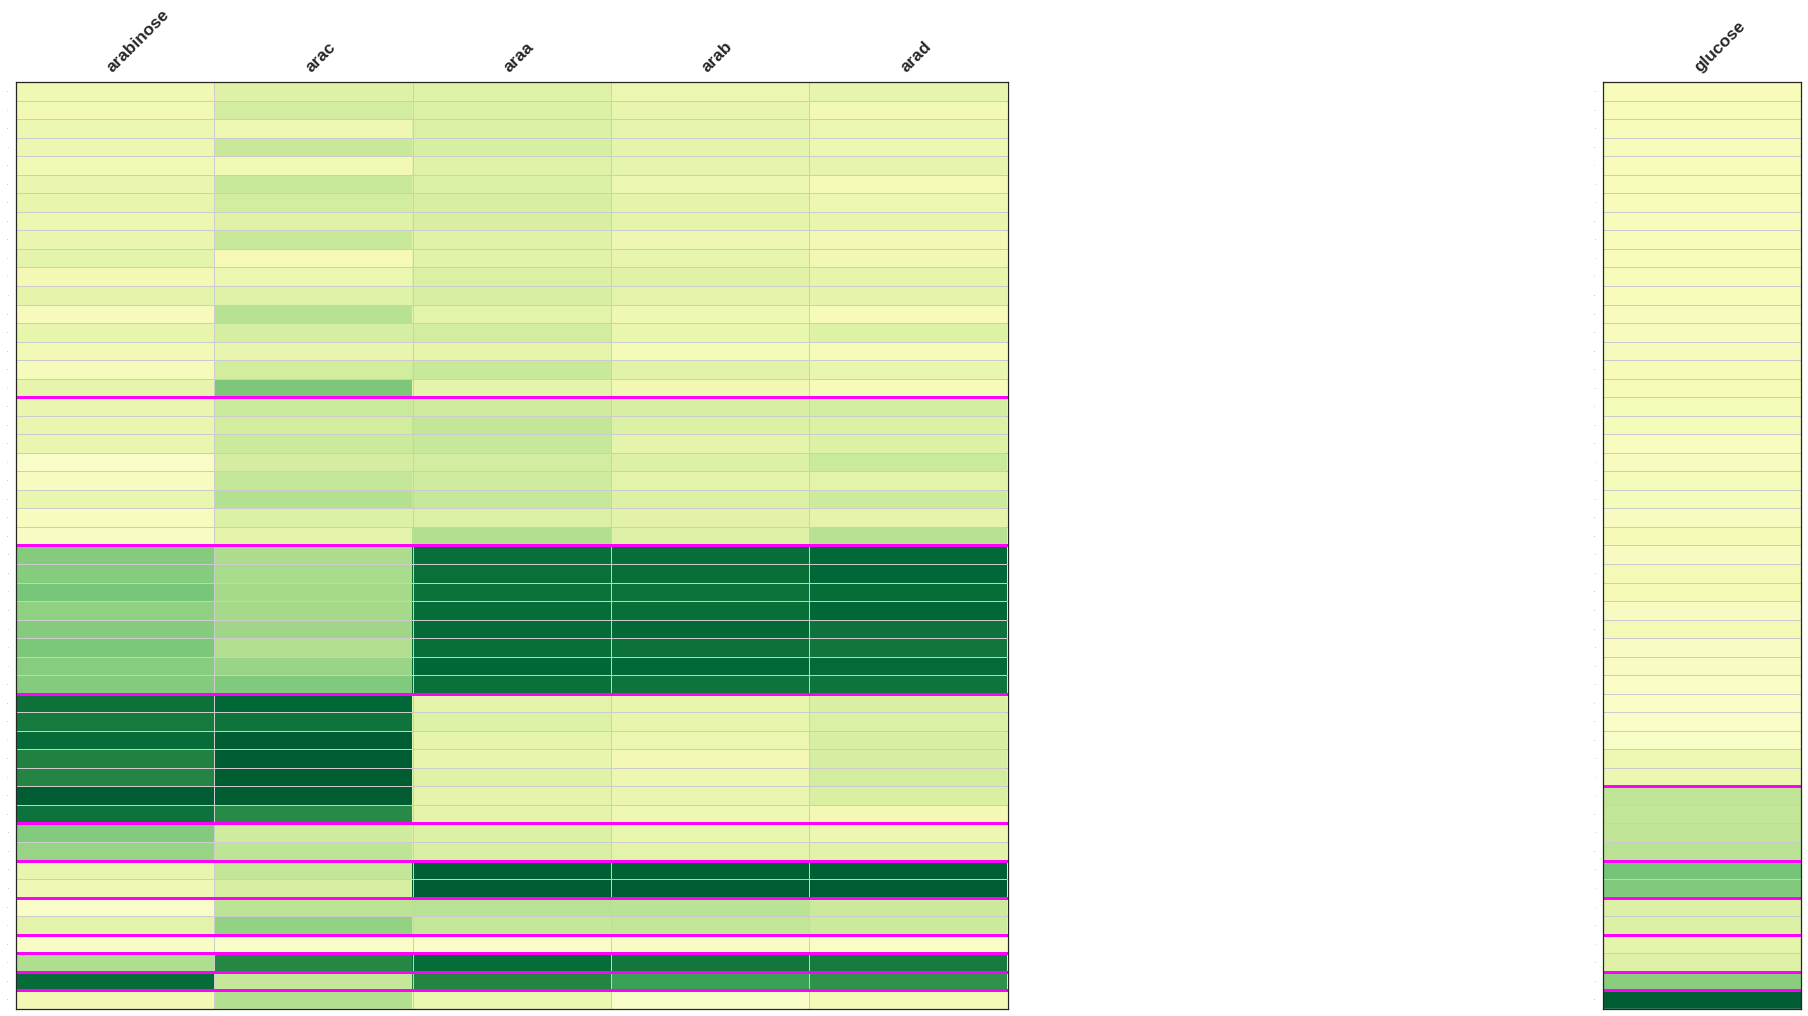

In [28]:
%mml .render_crosscat --subsample=50 data 7

We can define a function to compute the fraction of times two columns end up
dependent in the code.

In [29]:
def count_structural_dependence(col1, col2):
    """Check the synthesized code to check how often two columns are dependent."""
    count = 0.
    for line_of_code in code.split("\n"):
        if 'define cluster-id' in line_of_code:
            if col1 in line_of_code and col2 in line_of_code:
                count+=1.
    return count/n_models

What is the probability given the code of 10 models that `glucose`
and `araD` are dependent?

In [30]:
count_structural_dependence('glucose', 'araD')

0.6

Note that so far, we have only generated code for 10 out of the  30 models in
the ensemble.

In [31]:
n_models = 30
code = load_synthesized_code(bdb, n_models=n_models)
# Let's recompute the probability of dependence given code for all 30 models in the ensemble.
count_structural_dependence('glucose', 'araD')

0.7

The BQL language provides a convenient user interface to write such a query to
synthesized code.

In [32]:
%%bql 
ESTIMATE DEPENDENCE PROBABILITY OF
    "glucose" WITH "araD"  AS "Probability of dependence"
    FROM "data"
    LIMIT 1

,Probability of dependence
0,0.7


This allows a user to write and combine more interesting queries. For example,
we can create a table for all pairwise, dependencies of columns in the data. This provides
insights in predictive relationships. A cell (between 0 and 1) is the fraction of posterior CrossCat models in the ensemble where those
 two variables are detected to be probably dependent (i.e. they are in the same  column grouping).m

In [33]:
%%bql
CREATE TABLE "dependencies" AS
ESTIMATE
    DEPENDENCE PROBABILITY AS "Probability of dependence"
FROM PAIRWISE VARIABLES OF data;

Name already defined as table: 'dependencies'


We can show the results of this analysis for the column `glucose`.

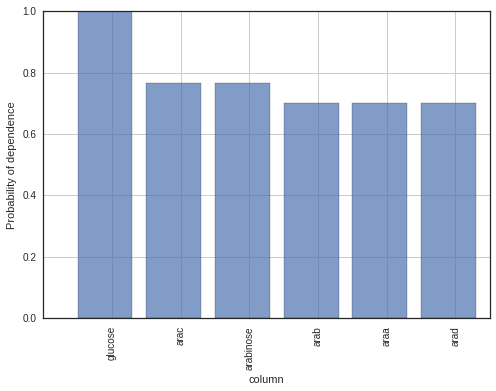

In [34]:
%bql .bar SELECT "name1" AS "column", "Probability of dependence"\
    FROM "dependencies"  WHERE "name0" == 'glucose' ORDER BY "Probability of dependence" DESC

The plot above corresponds to one row below.

In [35]:
%bql .interactive_heatmap SELECT name0, name1, "Probability of dependence" FROM dependencies;

<IPython.core.display.Javascript object>

#### Comparison to linear statistics

Let us compare dependence probabilities from CrossCat to linear (Pearson r) correlation values, a very common technique for finding predictive relationships. We can compute the Pearson R (and its p-value) in BayesDB using the `CORRELATION` and `CORRELATION PVALUE` queries. The following cell creates a table named `correlations`, which contains the R and p-value for all pairs of variables.

In [36]:
%%bql
CREATE TABLE "correlations" AS
ESTIMATE
    CORRELATION AS "correlation",
    CORRELATION PVALUE AS "pvalue"
FROM PAIRWISE VARIABLES OF "data"

Name already defined as table: 'correlations'


Plotting all the pairwise correlations reveals that linear analysis misses many
predictive relationship that our query for `DEPENDENCE PROBABILITY` finds:

In [37]:
%bql .interactive_heatmap SELECT name0, name1, "correlation" FROM "correlations"

<IPython.core.display.Javascript object>

## 4. Simple hypothesis testing: BayesDB agrees with linear statistics. 

Finally, we get to test hypotheses. In the following, we will confirm that
BayesDB finds relationships in the data that we know should be there. For every
hypothesis test, we compare BayesDB with a linear method (regression/correlation/partial
correlation).

We start with a simple case. One experimental treatment should not effect the
other -- they should be statistically independent; which is confirmed by running
a regression and BayesDB.

#### Linear statistics

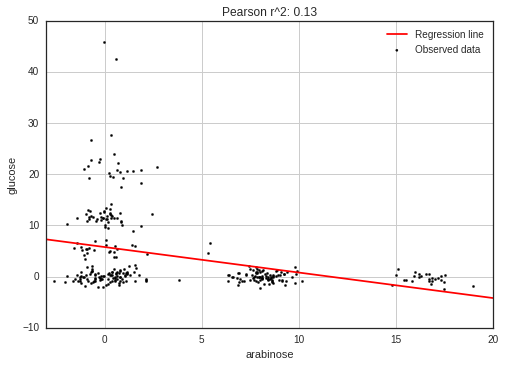

In [38]:
data = %bql SELECT * FROM "data"
fig, ax = corr_plots('arabinose', 'glucose', data, xlims=[-3, 20])

#### BayesDB

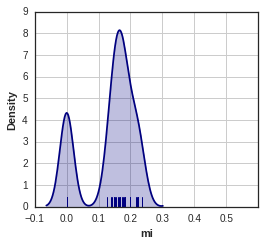

In [39]:
%bql .density --xmax=0.6 SIMULATE MUTUAL INFORMATION OF "arabinose" WITH  "glucose" USING 200 SAMPLES FROM MODELS OF "data"

## 5. Simple hypothesis testing: BayesDB finds a dependency that linear statistics misses.

Next, we show a case where two genes are informative for each other. We know
this is true  because the two genes, `araC` and `araA`, live on the same
[operon](https://ecocyc.org/gene?orgid=ECOLI&id=EG10054#tab=TU).
However, the relationship is not well modelled by a line. 
Thus, regression does not detect it but BayesDB does.

#### Linear statistics

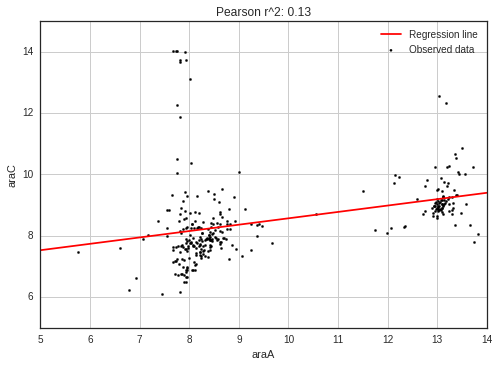

In [40]:
fig, ax = corr_plots('araA', 'araC', data, xlims=[5, 14])

#### BayesDB

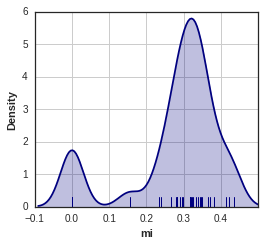

In [41]:
%bql .density  --xmax=0.5 SIMULATE MUTUAL INFORMATION OF "araA" WITH  "araC" USING 200 SAMPLES FROM MODELS OF "data"

## 6. Causal hypothesis testing: BayesDB finds a evidence for a causal structure.

Sections 4. and 5. showed fairly simple examples of pairwise relationships. But
BayesDB allows for testing for richer, causal hypotheses, too.


The following diagram describes the causal ground truth between three variables in our
data set. `araC` is a gene that is effected by both `Arabinose` and `Glucose`
(see [this summary of `araC`)](https://ecocyc.org/gene?orgid=ECOLI&id=EG10054#).
Arabinose and glucose are both experimental variables treatments. We can assume
that their administration is independent (there is no edge between `Arabinose` and `Glucose`).

![causal-dag-pic](araC-dag-structure.jpg "causal structure")



If we know that the causal structure (above) holds, then the following
relationships are implied and should inferable through the data:

* Arabinose$\,\;\not\!\perp\!\!\!\perp$ araC 
* Glucose  $\;\;\;\not\!\perp\!\!\!\perp$ araC
* Arabinose$\;\perp \!\!\! \perp$ Glucose"
* Arabinose  $\;\not\!\perp\!\!\!\perp$ Glucose | araC

Where $\perp \!\!\! \perp$ and $\not\!\perp\!\!\!\perp$ means statistical independence and dependence.
Note that conditioning on araC breaks independence between glucose and
arabinose.

Let's define those relationships and then see how we can investigate evidence
for those relationships with (i) linear statistics and (ii) BayesDB.

In [42]:
relationships = [
    'arabinose with araC',
    'glucose with araC',
    'arabinose with glucose',
    'arabinose with glucose given araC'
]

#### Linear statistics
We compare against [partial correlation](https://en.wikipedia.org/wiki/Partial_correlation) for the case where we condition on `araC`.

In [43]:
# Linear correlation out of BQL
corr_xz         = %bql ESTIMATE CORRELATION OF  "arabinose" WITH "araC"    AS "r" BY "data"
corr_yz         = %bql ESTIMATE CORRELATION OF  "glucose"   WITH "araC"    AS "r" BY "data"
corr_xy         = %bql ESTIMATE CORRELATION OF  "arabinose" WITH "glucose" AS "r" BY "data"
# Partial correlation with python.
df = %bql SELECT "arabinose", "glucose", "araC"  FROM data
corr_xy_given_z = partial_correlation(df.values)
corr_estimates = [corr_xz, corr_yz, corr_xy, corr_xy_given_z]

#### BayesDB

In [45]:
mi_xz = %bql SIMULATE MUTUAL INFORMATION OF "arabinose" WITH "araC"    USING 200 SAMPLES FROM MODELS OF "data"
mi_yz = %bql SIMULATE MUTUAL INFORMATION OF "glucose"   WITH "araC"    USING 200 SAMPLES FROM MODELS OF "data"
mi_xy = %bql SIMULATE MUTUAL INFORMATION OF "arabinose" WITH "glucose" USING 200 SAMPLES FROM MODELS OF "data"
mi_xy_given_z = %bql SIMULATE MUTUAL INFORMATION OF "arabinose" WITH "glucose" GIVEN ("araC" = 13) \
    USING 200 SAMPLES FROM MODELS OF "data"
mi_estimates = [mi_xz, mi_yz, mi_xy, mi_xy_given_z]

### Comparison

In [48]:
for i, corr in enumerate(corr_estimates):
    print 'Pearson r^2 of {}: {}'.format(relationships[i], corr.values[0,0])

Pearson r^2 of arabinose with araC: 0.348549581457
Pearson r^2 of glucose with araC: 0.178836856802
Pearson r^2 of arabinose with glucose: 0.134633384965
Pearson r^2 of arabinose with glucose given araC: 0.130964395667


In [51]:
for i, mi in enumerate(mi_estimates):
    print 'Mutial information of {}: {}'.format(relationships[i], mi.mean()[0])

Mutial information of arabinose with araC: 0.314877158251
Mutial information of glucose with araC: 0.140888520128
Mutial information of arabinose with glucose: 0.141158145967
Mutial information of arabinose with glucose given araC: 0.224143703891


The final value if shifting if one conditions on araC! Let's visualize the posterior
distribution of mutual information.

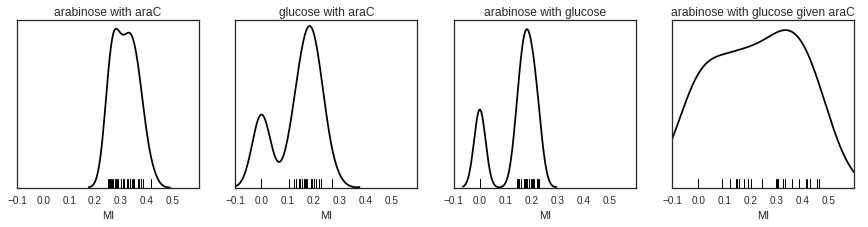

In [46]:
plot_information_flow(mi_estimates, relationships)